<b>Problem statement</b>: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [23]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [24]:
!ls "/content/drive/My Drive/ML Notebooks"

'Melanoma Detection_CNN.ipynb'	 Skin_cancer


### Importing all the important libraries

In [81]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, InputLayer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [26]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/My Drive/ML Notebooks/Skin_cancer/Train/")
data_dir_test = pathlib.Path("/content/drive/My Drive/ML Notebooks/Skin_cancer/Test/")

In [27]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

In [28]:
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180
input_shape = (img_height,img_width,3)

In [29]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    label_mode='categorical',seed=123)

Found 2239 files belonging to 9 classes.


Use 80% of the images for training, and 20% for validation.

In [30]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    label_mode='categorical',seed=123, subset="training", validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [31]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    label_mode='categorical',seed=123, subset="validation", validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [32]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [33]:
num_classes = len(class_names)
print(num_classes)

9


### Visualize the data

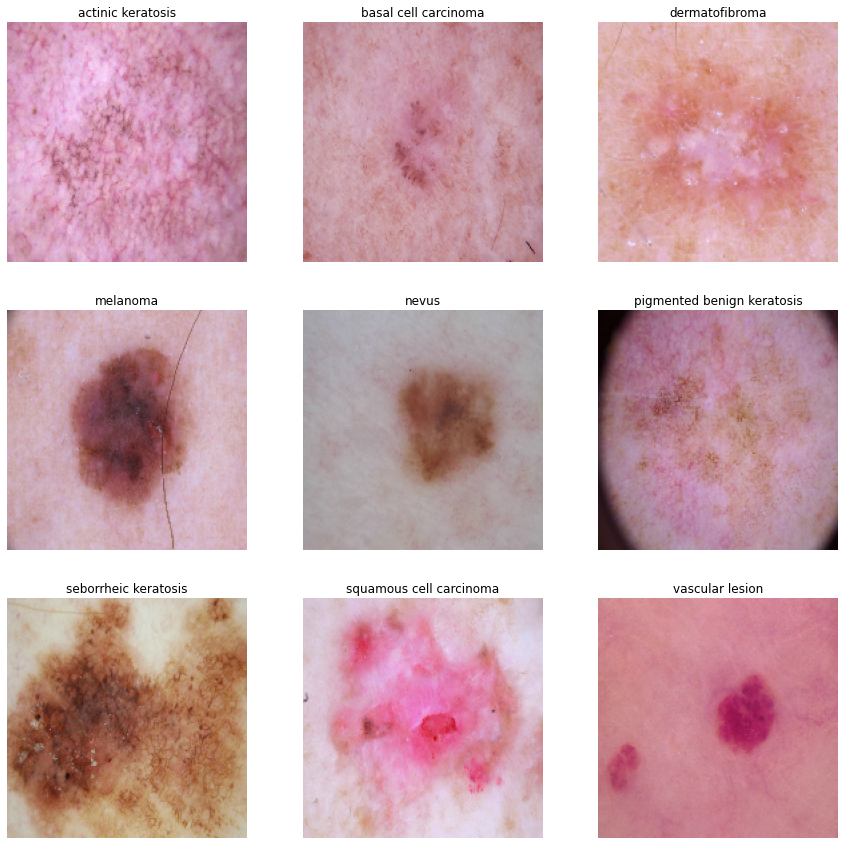

In [34]:
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [35]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create a basic model
The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu').

In [36]:
# first CNN model
model = Sequential()

#Rescaling/ Normalization layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))

# first convolution layer
model.add(Conv2D(25, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolution layer
model.add(Conv2D(50, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolution layer
model.add(Conv2D(100, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth convolution layer
model.add(Conv2D(200, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layer
model.add(layers.Dropout(0.4))

# Flatten layer
model.add(Flatten())

# First fully connected layer
model.add(Dense(200, activation='relu')) # fully connected

#Dropout layer
model.add(layers.Dropout(0.2))

#Final fully connected layer with softmax activation
model.add(Dense(num_classes, activation='softmax'))



In [37]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 25)      700       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 25)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 50)        11300     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 50)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 41, 41, 100)      

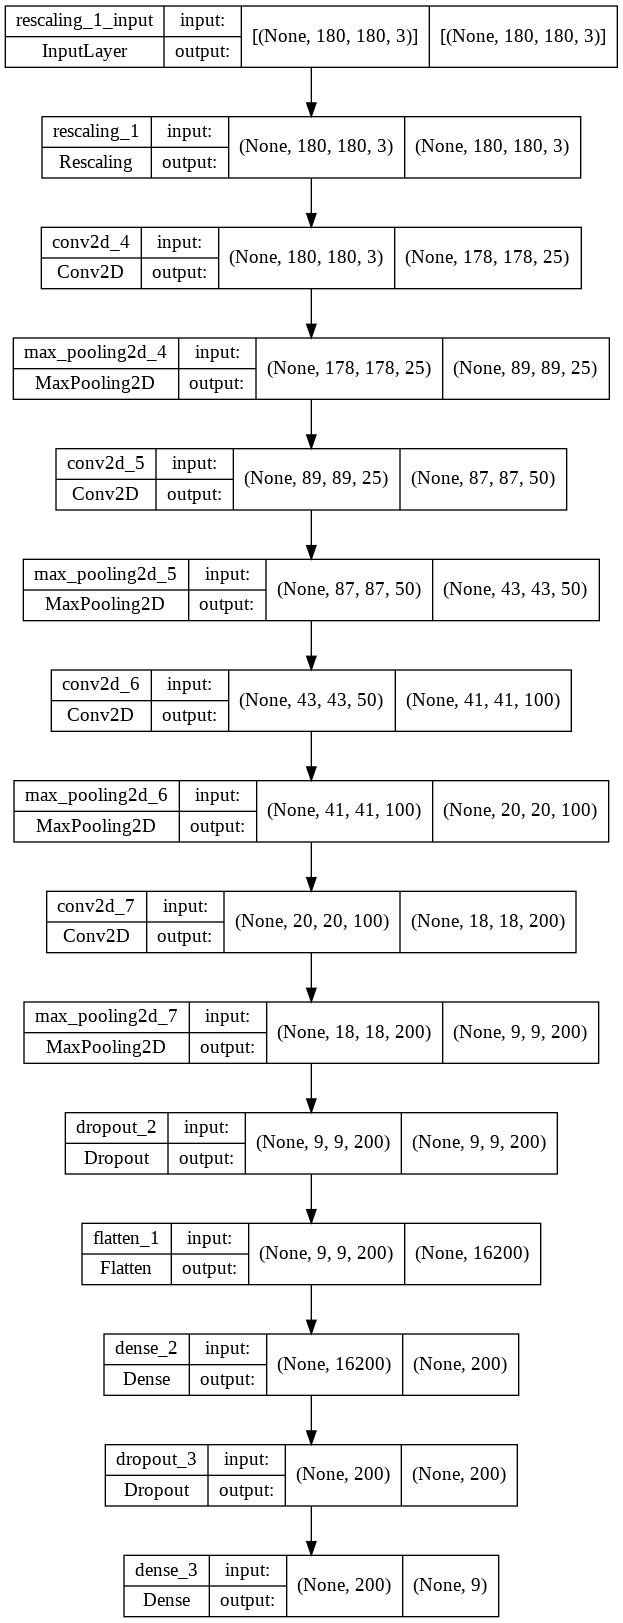

In [38]:
# Plotting the model
plot_model(model, to_file='basic_model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the model

In [39]:
# usual cross entropy loss
# optimizer adam
# metric is accuracy
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer="Adam",
              metrics=['accuracy'])

In [40]:
# model checkpoint
model_checkpoint = ModelCheckpoint("basic_model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [41]:
# Early stopping
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [42]:
# Fit the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[model_checkpoint,earlystop])

Epoch 1/20
55/56 [============================>.] - ETA: 0s - loss: 2.0083 - accuracy: 0.2250
Epoch 1: val_accuracy improved from -inf to 0.32662, saving model to basic_model.h5
56/56 [==============================] - 256s 927ms/step - loss: 2.0046 - accuracy: 0.2277 - val_loss: 1.7860 - val_accuracy: 0.3266
Epoch 2/20
55/56 [============================>.] - ETA: 0s - loss: 1.7132 - accuracy: 0.3631
Epoch 2: val_accuracy improved from 0.32662 to 0.41834, saving model to basic_model.h5
56/56 [==============================] - 2s 37ms/step - loss: 1.7095 - accuracy: 0.3650 - val_loss: 1.6463 - val_accuracy: 0.4183
Epoch 3/20
55/56 [============================>.] - ETA: 0s - loss: 1.5798 - accuracy: 0.4437
Epoch 3: val_accuracy improved from 0.41834 to 0.44966, saving model to basic_model.h5
56/56 [==============================] - 2s 37ms/step - loss: 1.5767 - accuracy: 0.4436 - val_loss: 1.4769 - val_accuracy: 0.4497
Epoch 4/20
55/56 [============================>.] - ETA: 0s - loss:

### Visualize training result

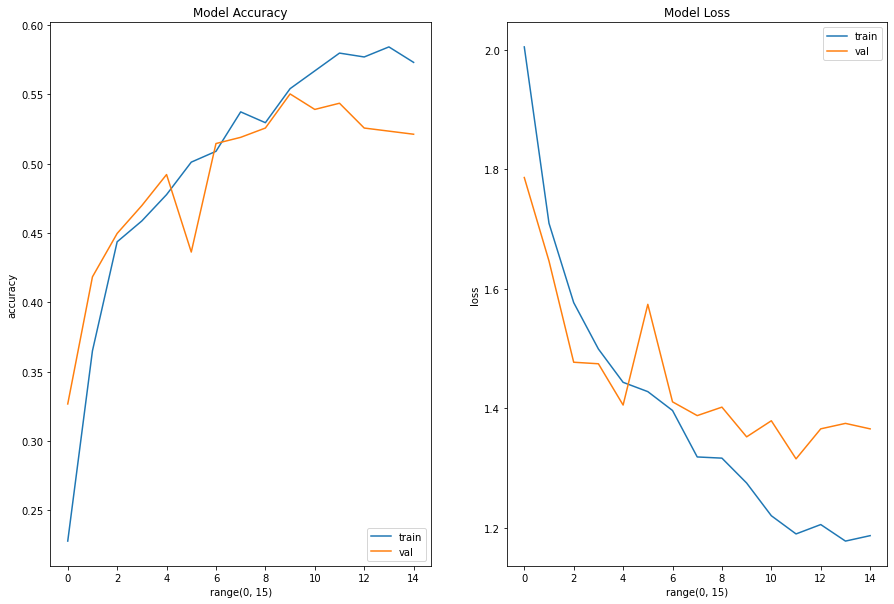

In [43]:
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='lower right')

#Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Findings from the basic model
As we can see from the above image that training and validation accuracy both are much below 70%, we can conclude that model is underfit. We can rebuild the model by changing some layers to improve it.

In [44]:
# Second CNN model
model = Sequential()

#Rescaling/ Normalization layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))

# first convolution layer
model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolution layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolution layer
model.add(Conv2D(128, kernel_size=(3, 3), 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Dropout(0.25))

# Flatten layer
model.add(Flatten())

# First fully connected layer
model.add(Dense(128, activation='relu')) # fully connected

#Dropout layer
model.add(layers.Dropout(0.5))

#Final fully connected layer with softmax activation
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 87, 87, 64)      

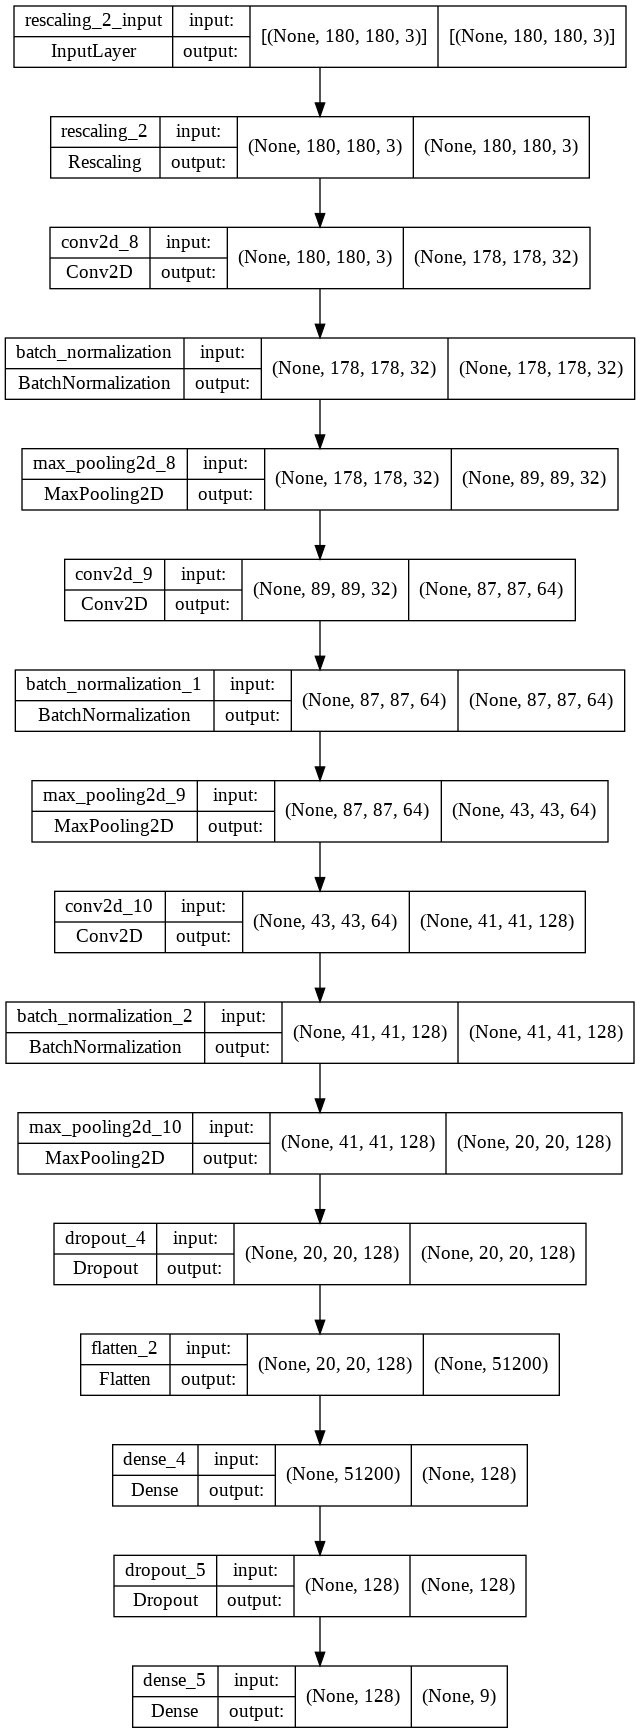

In [45]:
# Plot second model
plot_model(model, to_file='second_model_plot.png', show_shapes=True, show_layer_names=True)

In [46]:
model_checkpoint = ModelCheckpoint("second_model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [47]:
# usual cross entropy loss
# optimizer Adam
# metric is accuracy
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer="Adam",
              metrics=['accuracy'])

In [48]:
# fit second model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[model_checkpoint,earlystop])

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 7.7451 - accuracy: 0.2595
Epoch 1: val_accuracy improved from -inf to 0.08725, saving model to second_model.h5
56/56 [==============================] - 4s 61ms/step - loss: 7.7451 - accuracy: 0.2595 - val_loss: 7.5127 - val_accuracy: 0.0872
Epoch 2/20
55/56 [============================>.] - ETA: 0s - loss: 2.5796 - accuracy: 0.2648
Epoch 2: val_accuracy improved from 0.08725 to 0.20582, saving model to second_model.h5
56/56 [==============================] - 3s 50ms/step - loss: 2.5770 - accuracy: 0.2662 - val_loss: 8.8225 - val_accuracy: 0.2058
Epoch 3/20
55/56 [============================>.] - ETA: 0s - loss: 2.1686 - accuracy: 0.3006
Epoch 3: val_accuracy improved from 0.20582 to 0.22148, saving model to second_model.h5
56/56 [==============================] - 3s 51ms/step - loss: 2.1739 - accuracy: 0.3019 - val_loss: 11.4732 - val_accuracy: 0.2215
Epoch 4/20
55/56 [============================>.] - ETA: 0s - loss

### Finding
Again the model is underfit. We have to check the distribution of classes in the training dataset.

In [49]:
# Finding distribution of classes
count= []
for path in pathlib.Path(data_dir_train).iterdir():
    if path.is_dir():
        count.append(len([name for name in os.listdir(path)
                            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(data_dir_train)
                if os.path.isdir(os.path.join(data_dir_train, name))]

#return dataframe with image count and class.
df = pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

In [50]:
print(df)

                        Class  No. of Image
0  pigmented benign keratosis           462
1                       nevus           357
2        seborrheic keratosis            77
3                    melanoma           438
4              dermatofibroma            95
5        basal cell carcinoma           376
6     squamous cell carcinoma           181
7             vascular lesion           139
8           actinic keratosis           114


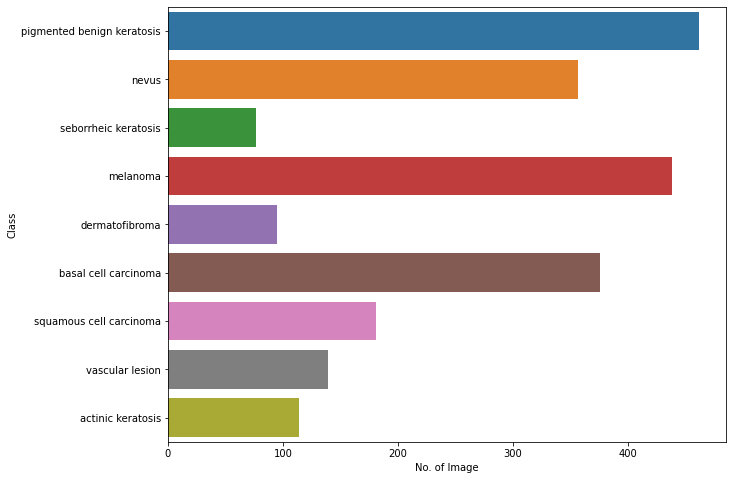

In [51]:
plt.figure(figsize=(10, 8))
sns.barplot(data=df, y="Class", x="No. of Image")

### Observation
It can be clearly observed that there is class imbalance here. To solve this, we have to add more samples to every classes so that no one of classes has very few samples.

In [52]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [53]:
import Augmentor

In [54]:
path_to_training_dataset="/content/drive/My Drive/ML Notebooks/Skin_cancer/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/ML Notebooks/Skin_cancer/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC15A3037D0>: 100%|██████████| 500/500 [00:22<00:00, 22.62 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/ML Notebooks/Skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC16E268CD0>: 100%|██████████| 500/500 [00:23<00:00, 21.27 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/ML Notebooks/Skin_cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC15A055450>: 100%|██████████| 500/500 [00:23<00:00, 21.73 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/ML Notebooks/Skin_cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC1EDB10CD0>: 100%|██████████| 500/500 [01:24<00:00,  5.92 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/ML Notebooks/Skin_cancer/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7FC1E037ED50>: 100%|██████████| 500/500 [01:30<00:00,  5.55 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/ML Notebooks/Skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC15A2E0510>: 100%|██████████| 500/500 [00:19<00:00, 25.55 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/ML Notebooks/Skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC1E022EAD0>: 100%|██████████| 500/500 [00:45<00:00, 11.04 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/ML Notebooks/Skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC14B70DFD0>: 100%|██████████| 500/500 [00:19<00:00, 25.69 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/ML Notebooks/Skin_cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC16E2BB610>: 100%|██████████| 500/500 [00:19<00:00, 26.08 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [55]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [56]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/My Drive/ML Notebooks/Skin_cancer/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025986.jpg_1f85408b-1236-43f9-aa72-fa6f1323ceb8.jpg',
 '/content/drive/My Drive/ML Notebooks/Skin_cancer/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027957.jpg_04abb48a-89a7-4765-92ed-c924698b2667.jpg',
 '/content/drive/My Drive/ML Notebooks/Skin_cancer/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025030.jpg_18d32b7f-d2c8-45d4-90b6-fadda7547075.jpg',
 '/content/drive/My Drive/ML Notebooks/Skin_cancer/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025286.jpg_a0fb7c87-a1ab-471f-b23e-3eba7c5202dc.jpg',
 '/content/drive/My Drive/ML Notebooks/Skin_cancer/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024708.jpg_5dfb46ed-94f0-4532-8439-7aaf68969df1.jpg',
 '/content/drive/My Drive/ML Notebooks/Skin_cancer/Train/pigmente

In [57]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [58]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [59]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [60]:
df2['Label'].value_counts()

pigmented benign keratosis    500
nevus                         500
seborrheic keratosis          500
melanoma                      500
dermatofibroma                500
basal cell carcinoma          500
squamous cell carcinoma       500
vascular lesion               500
actinic keratosis             500
Name: Label, dtype: int64

So, now we have added 1000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [61]:
batch_size = 32
img_height = 180
img_width = 180
epochs = 30

#### Create a training dataset 

In [62]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    labels='inferred',label_mode='categorical',seed=123, subset="training", validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation set

In [63]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    labels='inferred',label_mode='categorical',seed=123, subset="validation", validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Model creation


In [64]:
# Third CNN model after Augmentation
model = Sequential()

#Rescaling/ Normalization layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))

# first convolution layer
model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolution layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolution layer
model.add(Conv2D(128, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Dropout(0.25))

# Flatten layer
model.add(Flatten())

# First fully connected layer
model.add(Dense(256, activation='relu')) # fully connected

#Dropout layer
model.add(layers.Dropout(0.5))

#Final fully connected layer with softmax activation
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 41, 41, 128)      

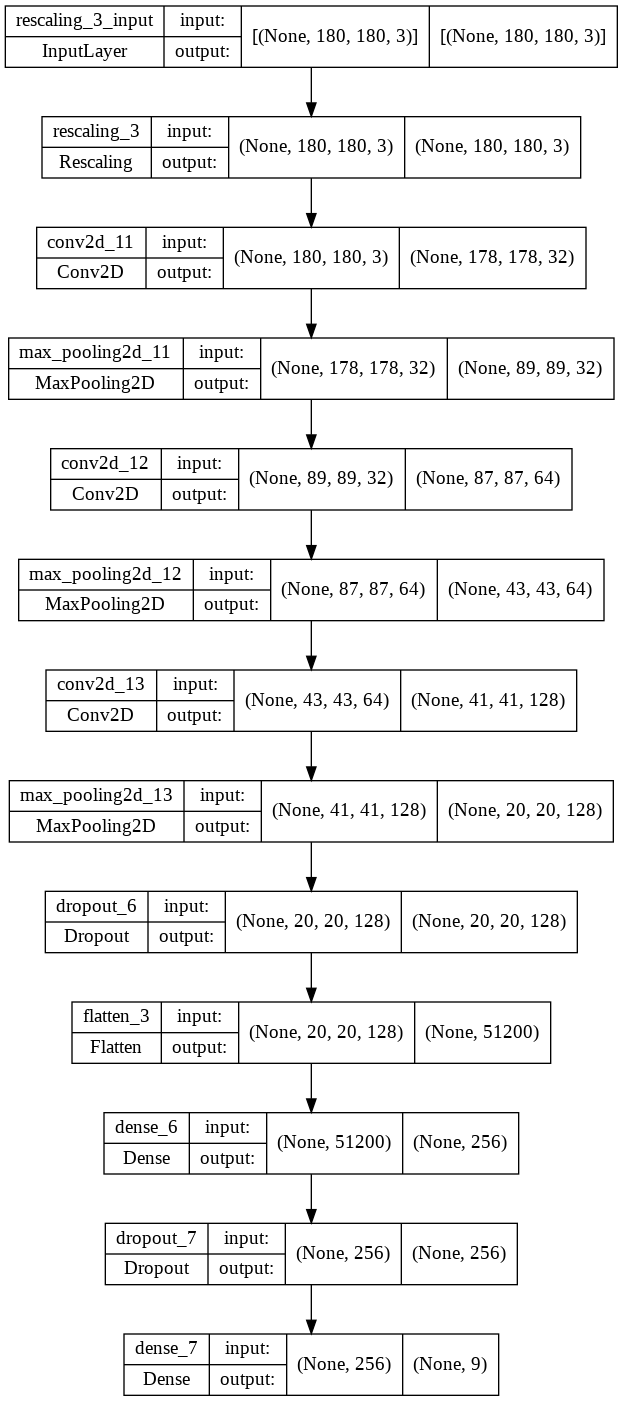

In [65]:
plot_model(model, to_file='third_model.png', show_shapes=True, show_layer_names=True)

In [66]:
# compile the model
checkpoint = ModelCheckpoint("third_model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

model.compile(optimizer="Adam",loss=tf.keras.losses.categorical_crossentropy,metrics=["accuracy"])

In [67]:
# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 1.8904 - accuracy: 0.2704
Epoch 1: val_accuracy improved from -inf to 0.42762, saving model to third_model.h5
169/169 [==============================] - 45s 257ms/step - loss: 1.8904 - accuracy: 0.2704 - val_loss: 1.5436 - val_accuracy: 0.4276
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 1.5849 - accuracy: 0.3997
Epoch 2: val_accuracy improved from 0.42762 to 0.44469, saving model to third_model.h5
169/169 [==============================] - 32s 183ms/step - loss: 1.5849 - accuracy: 0.3997 - val_loss: 1.4278 - val_accuracy: 0.4447
Epoch 3/30
168/169 [============================>.] - ETA: 0s - loss: 1.4422 - accuracy: 0.4494
Epoch 3: val_accuracy improved from 0.44469 to 0.47439, saving model to third_model.h5
169/169 [==============================] - 32s 182ms/step - loss: 1.4435 - accuracy: 0.4494 - val_loss: 1.3724 - val_accuracy: 0.4744
Epoch 4/30
168/169 [============================>.] 

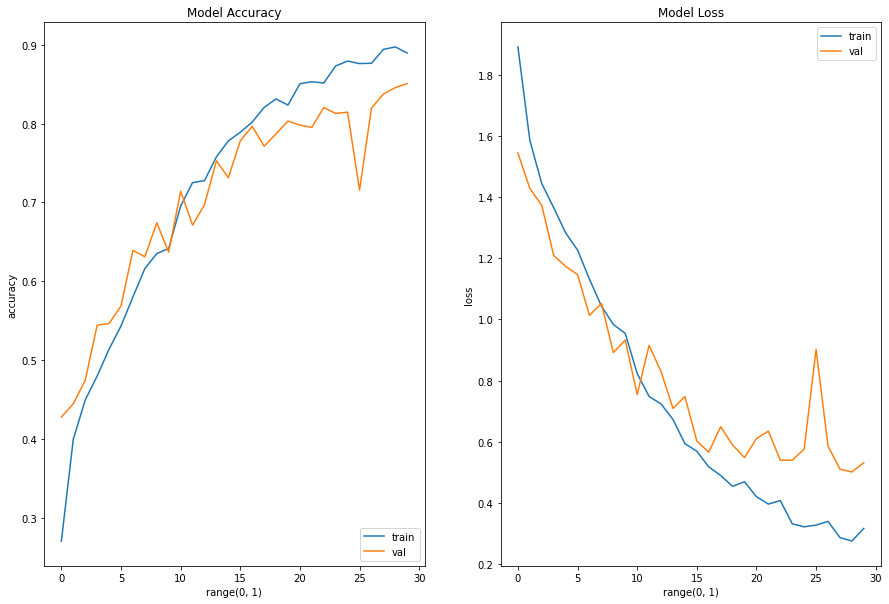

In [68]:
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='lower right')

#Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper right')
plt.show()

#### Evaluate the model for test images

Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


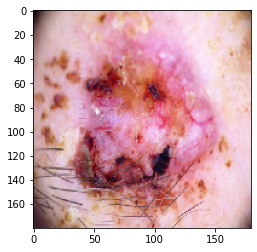

In [69]:
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

### Pre-trained CNN model(VGG-16) as Feature Extractor

In [70]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=[img_height, img_width] + [3])

#inputs = keras.Input(shape=(img_height, img_width, 3))
#output = vgg.layers[-1].output
#output = keras.layers.Flatten()(output)

vgg.trainable = False
for layer in vgg.layers:
    layer.trainable = False

#prediction = Dense(num_classes, activation='softmax')(x)
#vgg_model = Model(vgg.input, prediction)

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

58900480/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  from ipykernel import kernelapp as app


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fc1e02bab50>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7fc1edb5e890>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7fc1edb64850>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7fc16e25df50>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7fc1edb5ee50>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7fc1edb6e850>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7fc1edb5b850>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7fc1e00d34d0>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7fc1e00cbb50>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7fc1e00d4790>,block3_conv3,False


In [73]:
VGG16_model = Sequential()
VGG16_model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))
#VGG16_model.add(data_augmentation)
VGG16_model.add(vgg)
VGG16_model.add(Flatten())
VGG16_model.add(Dense(512, activation='relu'))
VGG16_model.add(Dropout(0.3))
VGG16_model.add(Dense(512, activation='relu'))
VGG16_model.add(Dropout(0.3))
VGG16_model.add(Dense(num_classes, activation='softmax'))
VGG16_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               6554112   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)              

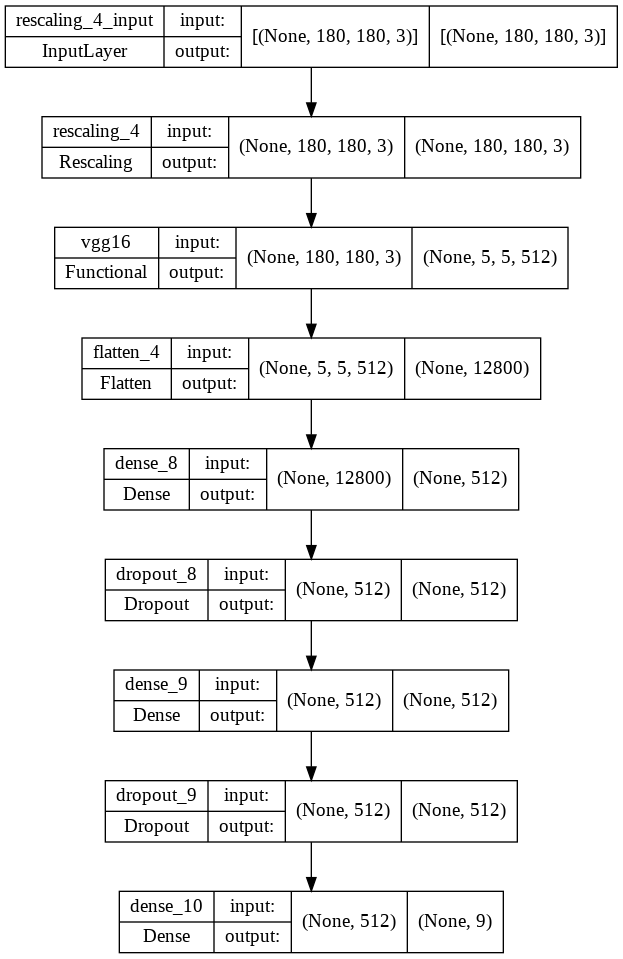

In [74]:
plot_model(VGG16_model, to_file='fourth_model.png', show_shapes=True, show_layer_names=True)

In [75]:
# compile the model
checkpoint = ModelCheckpoint("fourth_model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.categorical_crossentropy,metrics=["accuracy"])

In [76]:
# Train the model
history = VGG16_model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 1.9744 - accuracy: 0.2680
Epoch 1: val_accuracy improved from -inf to 0.39421, saving model to fourth_model.h5
169/169 [==============================] - 40s 213ms/step - loss: 1.9744 - accuracy: 0.2680 - val_loss: 1.7012 - val_accuracy: 0.3942
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 1.6195 - accuracy: 0.4188
Epoch 2: val_accuracy improved from 0.39421 to 0.50854, saving model to fourth_model.h5
169/169 [==============================] - 36s 204ms/step - loss: 1.6195 - accuracy: 0.4188 - val_loss: 1.4153 - val_accuracy: 0.5085
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.4044 - accuracy: 0.4941
Epoch 3: val_accuracy improved from 0.50854 to 0.56941, saving model to fourth_model.h5
169/169 [==============================] - 35s 201ms/step - loss: 1.4044 - accuracy: 0.4941 - val_loss: 1.2600 - val_accuracy: 0.5694
Epoch 4/30
169/169 [=============================

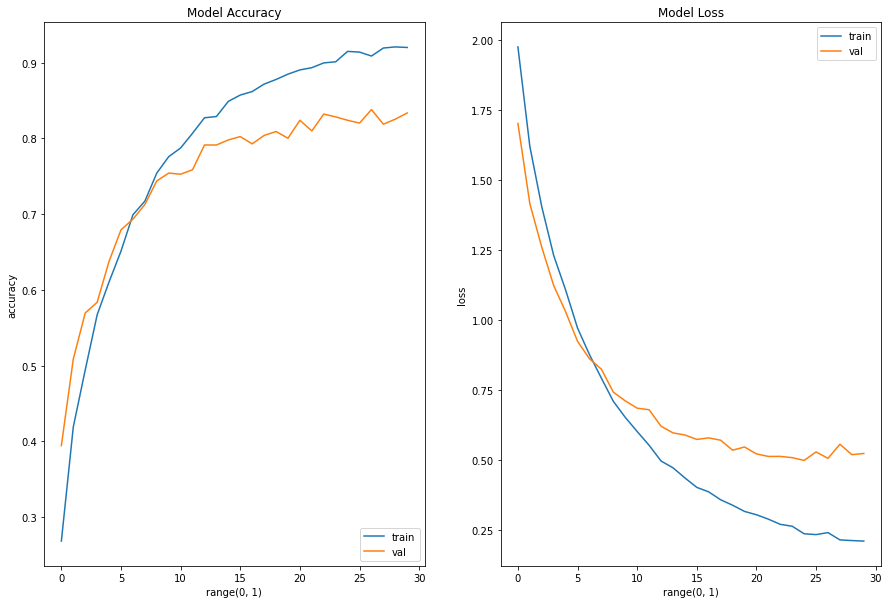

In [77]:
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='lower right')

#Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper right')
plt.show()

We can see that model is getting overfitted. So we will try with fine tuning the model with VGG-16 architecture.

Actual Class basal cell carcinoma
Predictive Class melanoma


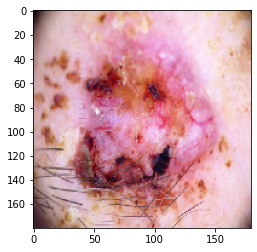

In [78]:
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = VGG16_model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

### Pre-Trained CNN Model(VGG-16) with Fine Tuning

In [79]:
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fc1e02bab50>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7fc1edb5e890>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7fc1edb64850>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7fc16e25df50>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7fc1edb5ee50>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7fc1edb6e850>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7fc1edb5b850>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7fc1e00d34d0>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7fc1e00cbb50>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7fc1e00d4790>,block3_conv3,False


In [82]:
VGG16_model = Sequential()
VGG16_model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))
VGG16_model.add(vgg)
VGG16_model.add(Flatten())
VGG16_model.add(Dense(512, activation='relu'))
VGG16_model.add(Dropout(0.3))
VGG16_model.add(Dense(512, activation='relu'))
VGG16_model.add(Dropout(0.3))
VGG16_model.add(Dense(num_classes, activation='softmax'))
VGG16_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 12800)             0         
                                                                 
 dense_11 (Dense)            (None, 512)               6554112   
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dropout_11 (Dropout)        (None, 512)              

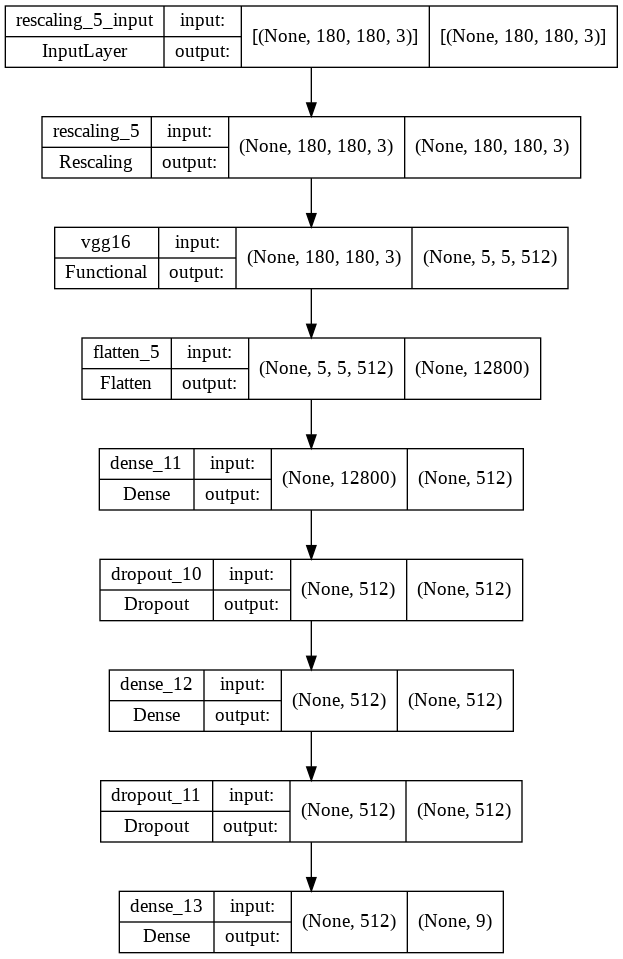

In [83]:
plot_model(VGG16_model, to_file='fifth_model.png', show_shapes=True, show_layer_names=True)

In [84]:
# compile the model
checkpoint = ModelCheckpoint("fourth_model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),loss=tf.keras.losses.categorical_crossentropy,metrics=["accuracy"])

In [85]:
# Train the model
history = VGG16_model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 1.9756 - accuracy: 0.2533
Epoch 1: val_accuracy improved from -inf to 0.47290, saving model to fourth_model.h5
169/169 [==============================] - 41s 227ms/step - loss: 1.9756 - accuracy: 0.2533 - val_loss: 1.4824 - val_accuracy: 0.4729
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 1.3524 - accuracy: 0.5061
Epoch 2: val_accuracy improved from 0.47290 to 0.61247, saving model to fourth_model.h5
169/169 [==============================] - 40s 232ms/step - loss: 1.3524 - accuracy: 0.5061 - val_loss: 1.0801 - val_accuracy: 0.6125
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.0706 - accuracy: 0.6091
Epoch 3: val_accuracy improved from 0.61247 to 0.67706, saving model to fourth_model.h5
169/169 [==============================] - 39s 226ms/step - loss: 1.0706 - accuracy: 0.6091 - val_loss: 0.8767 - val_accuracy: 0.6771
Epoch 4/30
169/169 [=============================

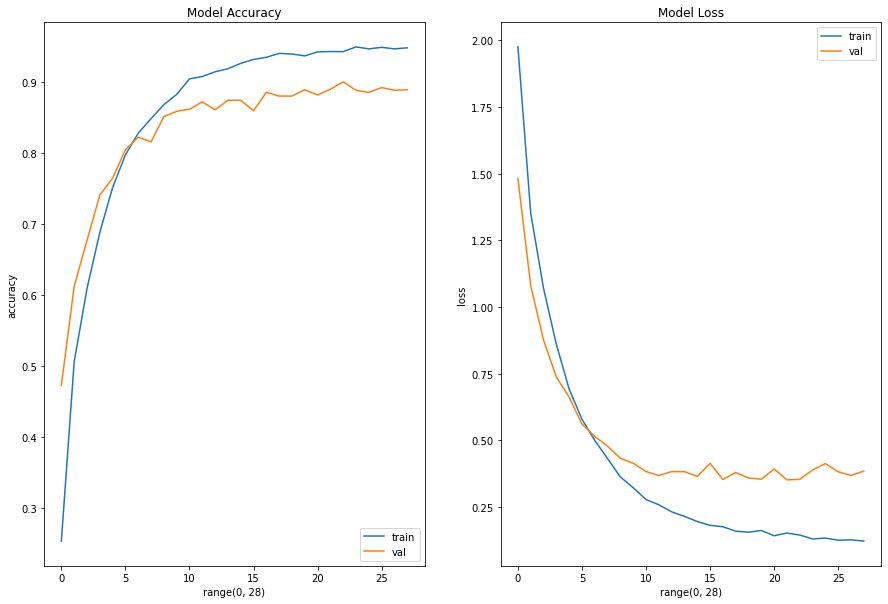

In [86]:
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='lower right')

#Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


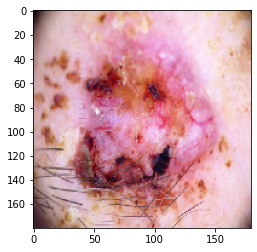

In [87]:
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = VGG16_model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )